# **Candidate Details**

- Surname & Name: *Donici Ionut Bogdan*
- ID: *34257A*
- Date Of Last Download & Correct Execution: *26/06/2024*

# **Milestone 0**: Downloading Dataset and Installing Libraries

In [1]:
# Installing required packages
!pip install kaggle pandas numpy scipy matplotlib seaborn tqdm

# Kaggle Config
!mkdir ~/.kaggle
!echo '{"username":"bogdandonici","key":"d483bed00c3e52b95d7e4c232de7ea1b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download Dataset
!kaggle datasets download -d gsimonx37/letterboxd

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
letterboxd.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile

# Extracting files
with zipfile.ZipFile("letterboxd.zip", "r") as zip_ref:
  # Unzip only .csv files, covers not required
  for file in zip_ref.namelist():
    if file.endswith('.csv'):
      zip_ref.extract(file, 'data')

# **Milestone 1**: Global Variables, Functions & Libraries

In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
# import nltk
# import string

from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [4]:
# Constants
FAST_MODE = True
# With TPU it could be higher
FM_PERCENTAGE = 0.01 # 1%
CHUNK_SIZE = 36_768 # Dimension of a chunk

In [5]:
def load_by_chunks_and_ids(path: str, indices):
  chunks = []
  for chunk in tqdm(pd.read_csv(path, chunksize=CHUNK_SIZE)):
    # Filter chunks by indices and append
    chunks.append(chunk[chunk['id'].isin(indices)])
  df = pd.concat(chunks)
  print(f"Shape of {path}: {df.shape}")
  return df


def create_set(film_users):
    # Create a set of all unique users from the film_users dictionary
    all_users = set()
    for film in film_users:
        for user in film_users[film]:
            all_users.add(user)
    return all_users


def create_idx(keys):
  # Create an index dictionary mapping each key to a unique index
  return {key : idx for idx, key in enumerate(keys)}


def reverse_dict(dictionary):
  # Reverse the key-value pairs in a dictionary
  return {value : key for key, value in dictionary.items()}


def create_utility_matrix(users):
  # Group users by film id and convert the grouped object to a dictionary
  # This will increase the creation of the csr_matrix since the dictionary
  # has an access time of O(1)
  users = users.groupby('id')['name'].apply(list).to_dict()

  # Create index mappings for films and users so we know at what col or row
  # are indexed
  film_indicies = create_idx(users.keys())
  user_indicies = create_idx(create_set(users))

  # Initialize the data structures for CSR matrix creation
  data = []
  indices = []
  indptr = [0]

  # Build the CSR matrix
  for film_id in tqdm(users):
      user_list = users[film_id]
      for user in user_list:
          col_index = user_indicies[user]
          # 1 indicates the association between the film and the user
          data.append(1)
          # Append the column index representing the user
          indices.append(col_index)
        # Append the current length of data to indptr
      indptr.append(len(data))

  # Create a CSR matrix with the collected data
  matrix = csr_matrix((data, indices, indptr), shape=(len(users.keys()), len(user_indicies)))

  # Since we have to access the utility_matrix, we also return the maps
  return matrix, reverse_dict(film_indicies), user_indicies


def construct_user_profile(user_name):
  # Get the indices of films associated with the given user in the utility matrix
  associated_film_ids = utility_matrix[:, user_map[user_name]].nonzero()[0]
  # Map the film indices back to their id
  film_ids = [film_map[film] for film in associated_film_ids]
  # Return the details of the films that the user had watched
  return movies.loc[movies['id'].isin(film_ids)].copy()


def get_recommendations(titles, cosine_sim, movies, indices):
    # Initialize an array to store the aggregate similarity scores (in case of
    # multiple titles)
    total_scores = np.zeros(cosine_sim.shape[0])

    for title in titles:
      # Get the index of the film
      idx = indices[title]
      # Extract score
      sim_scores = cosine_sim[idx]
      # Sum scores
      total_scores += sim_scores

    # Convert scores to a list of (movie_index, similarity_score) tuples
    sim_scores = list(enumerate(total_scores))

    # Sort the movies based on the aggregated similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N similar movies, excluding the input movies
    movie_indices = [i[0] for i in sim_scores if i[0] not in [indices[title] for title in titles]][:10]

    # Return the names of the top N recommendations
    return movies.iloc[movie_indices]

# **Milestone 2**: Importing Files & Preprocessing

## **Movie Table Preprocessing**

In [6]:
if FAST_MODE:
  # Loading and sampling the dataset without loading it entirely
  chunks = [] # <-- List to hold chunks
  for chunk in pd.read_csv('data/movies.csv', chunksize=CHUNK_SIZE):
    chunks.append(chunk.sample(frac=FM_PERCENTAGE))

  # Concatenate all chunks to get the DataFrame
  movies = pd.concat(chunks)
  print(f"New Shape of the sample: {movies.shape}")
else:
  # Load the full dataset
  movies = pd.read_csv("data/movies.csv")

New Shape of the sample: (8972, 7)


In [7]:
movies.head(5)

,id,name,date,tagline,description,minute,rating
24991,1024992,The Hummingbird,2022.0,NaN,Everyone in Marco's life seems constantly rest...,126.0,3.28
150,1000151,John Wick,2014.0,Don't set him off.,Ex-hitman John Wick comes out of retirement to...,101.0,3.80
20831,1020832,No Game No Life: Zero,2017.0,NaN,"In ancient Disboard, Riku is an angry, young w...",106.0,3.28
7668,1007669,By the Sea,2015.0,"When we die on the inside, the outside is left...","Set in France during the mid-1970s, Vanessa, a...",122.0,2.85
35830,1035831,Aravinda Sametha... Veera Raghava,2018.0,NaN,A young scion of a powerful family with a long...,162.0,3.26


In [8]:
# Index are not ordered, so
movies.reset_index(drop=True, inplace=True)

In [9]:
movies.info()

# Some columns have a lot of NaN values, we have to manage them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8972 entries, 0 to 8971
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8972 non-null   int64  
 1   name         8972 non-null   object 
 2   date         8126 non-null   float64
 3   tagline      1343 non-null   object 
 4   description  7395 non-null   object 
 5   minute       7135 non-null   float64
 6   rating       855 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 490.8+ KB


In [10]:
# Let's adjust the Dtypes of some columns

# 'intXX' is an integer type that does not support NaN values,
# whereas 'IntXX' allows for missing values

# Convert 'date' column to 'year' integer
movies['year'] = movies['date'].astype('Int16')
# Dropping rows that have NaN values for year
movies.dropna(subset=['year'], inplace=True)

# Remove unnecessary columns
# - date is removed because is substitued by year
# - tagline & description are removed due to fact that since the dataset is huge
# and so the TfIdf wasn't applicable... even if I tried to keep the 3 most
# relevant words
movies.drop(['date', 'tagline', 'description'], axis=1, inplace=True)

# Reset index after dropping
movies.reset_index(drop=True, inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8126 non-null   int64  
 1   name    8126 non-null   object 
 2   minute  6686 non-null   float64
 3   rating  855 non-null    float64
 4   year    8126 non-null   Int16  
dtypes: Int16(1), float64(2), int64(1), object(1)
memory usage: 277.9+ KB


In [11]:
movies.head(5)

,id,name,minute,rating,year
0,1024992,The Hummingbird,126.0,3.28,2022
1,1000151,John Wick,101.0,3.80,2014
2,1020832,No Game No Life: Zero,106.0,3.28,2017
3,1007669,By the Sea,122.0,2.85,2015
4,1035831,Aravinda Sametha... Veera Raghava,162.0,3.26,2018


### **Importing and Merging `genres`**

In [12]:
# Extract movie ids to filter rows during import
movie_ids = set(movies['id'].tolist())

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8126 non-null   int64  
 1   name    8126 non-null   object 
 2   minute  6686 non-null   float64
 3   rating  855 non-null    float64
 4   year    8126 non-null   Int16  
dtypes: Int16(1), float64(2), int64(1), object(1)
memory usage: 277.9+ KB


In [14]:
# Handling missing values

# The dataset info shows that some columns contain NaN values,
#
# IDEA: Calculate the mean of rating and minute by genre, then fill the empty cells.

genres = load_by_chunks_and_ids('data/genres.csv', indices=movie_ids)

0it [00:00, ?it/s]

Shape of data/genres.csv: (9613, 2)


In [15]:
# Looking at the data
genres.head()

,id,genre
20,1000008,Mystery
21,1000008,Comedy
22,1000008,Crime
414,1000151,Action
415,1000151,Thriller


In [16]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9613 entries, 20 to 990179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9613 non-null   int64 
 1   genre   9613 non-null   object
dtypes: int64(1), object(1)
memory usage: 225.3+ KB


In [17]:
# Let's aggregate genres by id
genres = genres.groupby('id')['genre'].apply(lambda x: ', '.join(set(x))).reset_index()

In [18]:
genres.head(5)

,id,genre
0,1000008,"Mystery, Crime, Comedy"
1,1000151,"Action, Thriller"
2,1000258,"Drama, Romance"
3,1000279,"Drama, Music"
4,1000281,"Action, Adventure, Fantasy"


In [19]:
# Merging the genres with movies
movies = movies.set_index('id').join(genres.set_index('id'), how='left').reset_index()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8126 non-null   int64  
 1   name    8126 non-null   object 
 2   minute  6686 non-null   float64
 3   rating  855 non-null    float64
 4   year    8126 non-null   Int16  
 5   genre   6126 non-null   object 
dtypes: Int16(1), float64(2), int64(1), object(2)
memory usage: 341.4+ KB


In [20]:
# Filling the missing genre with Unknown
movies['genre'].fillna('Unknown Genre', inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8126 non-null   int64  
 1   name    8126 non-null   object 
 2   minute  6686 non-null   float64
 3   rating  855 non-null    float64
 4   year    8126 non-null   Int16  
 5   genre   8126 non-null   object 
dtypes: Int16(1), float64(2), int64(1), object(2)
memory usage: 341.4+ KB


In [21]:
# Now we have the genre column without NaN values
movies.tail(5)

,id,name,minute,rating,year,genre
8121,1888181,At the Bottom,25.0,NaN,2011,Documentary
8122,1888306,A guerra dos avós,24.0,NaN,2007,Documentary
8123,1889287,Espérame hasta que acabe el invierno,7.0,NaN,2014,Unknown Genre
8124,1888542,Der Al Capone vom Donaumoos,62.0,NaN,1986,Documentary
8125,1887421,The Sky Above Zenica,90.0,NaN,2024,Documentary


### **Filling empty cells of `minute` and `rating`**

In [22]:
# Group genres and calculate the mean for minute and rating
genre_means = movies.groupby('genre')[['minute', 'rating']].mean()
genre_means

,minute,rating
genre,,
Action,90.925926,3.031667
"Action, Adventure",62.000000,NaN
"Action, Adventure, Comedy",96.500000,NaN
"Action, Adventure, Fantasy",119.500000,3.140000
"Action, Adventure, Fantasy, Family",95.000000,2.640000
...,...,...
Western,64.093023,3.286667
"Western, Adventure, Family, TV Movie, Action, Drama",96.000000,3.320000
"Western, Comedy",37.400000,3.130000


In [23]:
# As we can see there are some NaN values
# Let's fill the NaN values with the global mean of minute and rating of genre_means table
global_minute_mean = genre_means['minute'].mean()
global_rating_mean = genre_means['rating'].mean()

genre_means['minute'].fillna(global_minute_mean, inplace=True)
genre_means['rating'].fillna(global_rating_mean, inplace=True)
genre_means.tail(10)

,minute,rating
genre,,
"War, Adventure, Family",98.500000,3.204414
"War, Adventure, Family, Crime, Fantasy, Mystery, Action, History, Romance, Documentary, Drama",30.000000,3.204414
"War, Comedy",104.000000,3.130000
"War, Documentary",66.142857,3.470000
"War, History, Romance, Documentary, Drama",96.000000,3.204414
Western,64.093023,3.286667
"Western, Adventure, Family, TV Movie, Action, Drama",96.000000,3.320000
"Western, Comedy",37.400000,3.130000
"Western, Documentary",56.500000,3.204414


In [24]:
# Fill NaN values in 'minute' and 'rating' columns with genre means
movies['minute'].fillna(movies['genre'].map(genre_means['minute']), inplace=True)
movies['rating'].fillna(movies['genre'].map(genre_means['rating']), inplace=True)

In [25]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8126 non-null   int64  
 1   name    8126 non-null   object 
 2   minute  8126 non-null   float64
 3   rating  8126 non-null   float64
 4   year    8126 non-null   Int16  
 5   genre   8126 non-null   object 
dtypes: Int16(1), float64(2), int64(1), object(2)
memory usage: 341.4+ KB


As we can see there are **no more NaN** values in the dataset

In [26]:
movies.head(5)

,id,name,minute,rating,year,genre
0,1024992,The Hummingbird,126.0,3.28,2022,Drama
1,1000151,John Wick,101.0,3.80,2014,"Action, Thriller"
2,1020832,No Game No Life: Zero,106.0,3.28,2017,"Animation, Adventure, Fantasy, Action, Romance..."
3,1007669,By the Sea,122.0,2.85,2015,"Drama, Romance"
4,1035831,Aravinda Sametha... Veera Raghava,162.0,3.26,2018,"Action, Drama"


In [27]:
movies.tail(5)

,id,name,minute,rating,year,genre
8121,1888181,At the Bottom,25.0,3.472051,2011,Documentary
8122,1888306,A guerra dos avós,24.0,3.472051,2007,Documentary
8123,1889287,Espérame hasta que acabe el invierno,7.0,3.336667,2014,Unknown Genre
8124,1888542,Der Al Capone vom Donaumoos,62.0,3.472051,1986,Documentary
8125,1887421,The Sky Above Zenica,90.0,3.472051,2024,Documentary


Nice result!

### **Scaling `minute` and `rating`**

In [28]:
# Normalizing the minute and rating columns
scaler = MinMaxScaler()
movies[['minute', 'rating']] = scaler.fit_transform(movies[['minute', 'rating']])

In [29]:
movies.head(5)

,id,name,minute,rating,year,genre
0,1024992,The Hummingbird,0.074449,0.569492,2022,Drama
1,1000151,John Wick,0.059559,0.745763,2014,"Action, Thriller"
2,1020832,No Game No Life: Zero,0.062537,0.569492,2017,"Animation, Adventure, Fantasy, Action, Romance..."
3,1007669,By the Sea,0.072067,0.423729,2015,"Drama, Romance"
4,1035831,Aravinda Sametha... Veera Raghava,0.095890,0.562712,2018,"Action, Drama"


### **Importing `countries`**

I've chosen to import countries to have more features on which to rely when computing similarity.

In [30]:
countries = load_by_chunks_and_ids('data/countries.csv', indices=movie_ids)

0it [00:00, ?it/s]

Shape of data/countries.csv: (5986, 2)


In [31]:
countries.head(5)

,id,country
11,1000008,USA
205,1000151,USA
362,1000258,Australia
363,1000258,USA
395,1000279,USA


Now I'm doing the same procedure that I've had applied the `genres`

In [32]:
# Grouping by film id
countries = countries.groupby('id')['country'].apply(lambda country_list: ', '.join(set(country_list))).reset_index()
countries.head(10)

,id,country
0,1000008,USA
1,1000151,USA
2,1000258,"Australia, USA"
3,1000279,USA
4,1000281,USA
5,1000371,South Korea
6,1000423,USA
7,1000432,USA
8,1000504,USA
9,1000554,South Korea


In [33]:
# Merging with the movies table
movies = movies.set_index('id').join(countries.set_index('id'), how='left').reset_index()
movies.head(10)

,id,name,minute,rating,year,genre,country
0,1024992,The Hummingbird,0.074449,0.569492,2022,Drama,"France, Italy"
1,1000151,John Wick,0.059559,0.745763,2014,"Action, Thriller",USA
2,1020832,No Game No Life: Zero,0.062537,0.569492,2017,"Animation, Adventure, Fantasy, Action, Romance...",Japan
3,1007669,By the Sea,0.072067,0.423729,2015,"Drama, Romance","France, Malta, USA"
4,1035831,Aravinda Sametha... Veera Raghava,0.095890,0.562712,2018,"Action, Drama",India
5,1007563,Purl,0.004765,0.542373,2018,"Animation, Comedy",USA
6,1030082,Chie the Brat,0.061942,0.674576,1981,"Animation, Drama, Comedy, Family",Japan
7,1023493,New Year's Eve,0.083979,0.420339,2022,Comedy,Turkey
8,1005351,Jawan,0.100060,0.576271,2023,"Action, Thriller, Adventure",India
9,1005441,Newsies,0.071471,0.596610,1992,"History, Drama, Music, Family",USA


In [34]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       8126 non-null   int64  
 1   name     8126 non-null   object 
 2   minute   8126 non-null   float64
 3   rating   8126 non-null   float64
 4   year     8126 non-null   Int16  
 5   genre    8126 non-null   object 
 6   country  5366 non-null   object 
dtypes: Int16(1), float64(2), int64(1), object(3)
memory usage: 404.8+ KB


In [35]:
# Filling Empty Cells of country
movies['country'].fillna('Unknown Country', inplace=True)

In [36]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8126 entries, 0 to 8125
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       8126 non-null   int64  
 1   name     8126 non-null   object 
 2   minute   8126 non-null   float64
 3   rating   8126 non-null   float64
 4   year     8126 non-null   Int16  
 5   genre    8126 non-null   object 
 6   country  8126 non-null   object 
dtypes: Int16(1), float64(2), int64(1), object(3)
memory usage: 404.8+ KB


In [37]:
# Removing, if there are, duplicates
movies = movies.drop_duplicates(subset=['id', 'name'])

In [38]:
movies.shape

(8126, 7)

### One-Hot Encoding on Categorical Features `genres` and `countries`

In [39]:
# One Hot Encoding
movies = movies.join(movies['genre'].str.get_dummies(', '))
movies = movies.join(movies['country'].str.get_dummies(', '))

In [40]:
movies.head(5)

,id,name,minute,rating,year,genre,country,Action,Adventure,Animation,...,USSR,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,Unknown Country,Uruguay,Uzbekistan,Vietnam,Yugoslavia
0,1024992,The Hummingbird,0.074449,0.569492,2022,Drama,"France, Italy",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000151,John Wick,0.059559,0.745763,2014,"Action, Thriller",USA,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1020832,No Game No Life: Zero,0.062537,0.569492,2017,"Animation, Adventure, Fantasy, Action, Romance...",Japan,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1007669,By the Sea,0.072067,0.423729,2015,"Drama, Romance","France, Malta, USA",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1035831,Aravinda Sametha... Veera Raghava,0.095890,0.562712,2018,"Action, Drama",India,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Removing one-hot encoded columns
movies.drop(['genre', 'country'], axis=1, inplace=True)

In [42]:
movies.head(5)

,id,name,minute,rating,year,Action,Adventure,Animation,Comedy,Crime,...,USSR,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,Unknown Country,Uruguay,Uzbekistan,Vietnam,Yugoslavia
0,1024992,The Hummingbird,0.074449,0.569492,2022,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000151,John Wick,0.059559,0.745763,2014,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1020832,No Game No Life: Zero,0.062537,0.569492,2017,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1007669,By the Sea,0.072067,0.423729,2015,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1035831,Aravinda Sametha... Veera Raghava,0.095890,0.562712,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have our cleaned and preprocessed table let's implement the **content-based** recommendation method

# **Milestone 3**: Content-Based Recommendation System

Content-based systems focus on properties of the items.

We must construct for each item a **profile** (in this case the items are the movies), which is a record or collection of record representing important characteristics of that item. We've already a collection of profiles for each film, that is, the preprocessed table **movies**. We now extract the features of the profiles and then apply `cosine_similarity` on them in order to calculate the similarity between item profiles. Based on the results we'll be able to recommend films to the user.

In [43]:
# Extracting Features, note that all are numerical
movie_features = movies.drop(columns=['id', 'name'])
movie_features.head(5)

,minute,rating,year,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,USSR,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,Unknown Country,Uruguay,Uzbekistan,Vietnam,Yugoslavia
0,0.074449,0.569492,2022,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.059559,0.745763,2014,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.062537,0.569492,2017,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.072067,0.423729,2015,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.095890,0.562712,2018,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [44]:
cosine_sim = cosine_similarity(movie_features, movie_features)

Now that we have the cosine similarity calculated, we need to create the utility matrix to construct a user profile.

In this case, the user profile is simply a list of films that a user has already watched. Based on these films, we will recommend similar films to the user and provide a measure of similarity about the the suggested films to the films he already watched.


In [45]:
# Recreate again the set of ids to be sure we're importing only valid associations
movies_ids = set(movies['id'].tolist())

In [46]:
# Importing the users based on id
users = load_by_chunks_and_ids('data/actors.csv', indices=movies_ids)

0it [00:00, ?it/s]

Shape of data/actors.csv: (54318, 2)


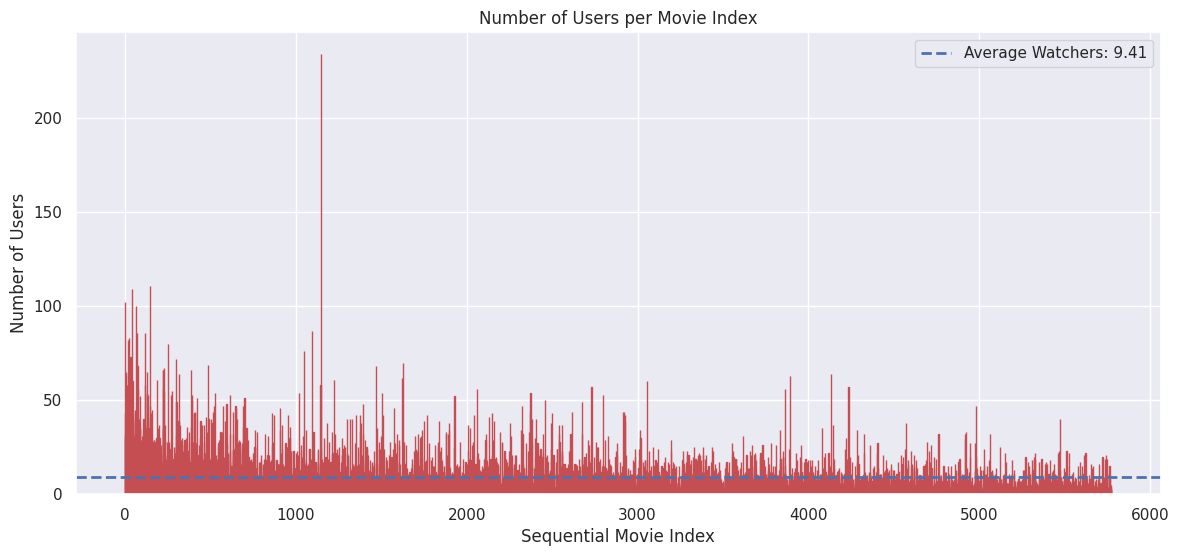

In [47]:
# Count the number of unique users for each movie and then plot the results
# This, to get an idea of the number of watchers per film and the average
# Also called curiosity

movie_user_counts = users.groupby('id')['name'].count()
average_watchers = movie_user_counts.mean()

sns.set(style="darkgrid")

plt.figure(figsize=(14, 6))

plt.bar(range(len(movie_user_counts)), movie_user_counts.values, edgecolor='r')
plt.axhline(average_watchers, color='b', linestyle='--', linewidth=2, label=f'Average Watchers: {average_watchers:.2f}')

plt.title('Number of Users per Movie Index')
plt.xlabel('Sequential Movie Index')
plt.ylabel('Number of Users')

plt.legend()
plt.show()

In [48]:
# Calculating the utility matrix
# Read inside the create_utility_matrix() for details
utility_matrix, film_map, user_map = create_utility_matrix(users)

  0%|          | 0/5773 [00:00<?, ?it/s]

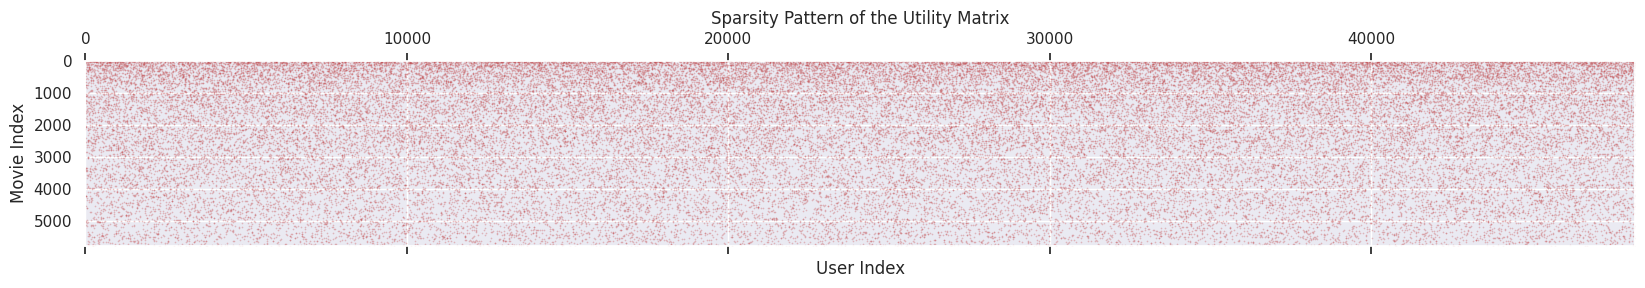

In [49]:
# Let's see the utility matrix

sns.set_theme(style='darkgrid')
plt.figure(figsize=(20,16))
plt.spy(utility_matrix, markersize=0.3, alpha=0.3, color='r')
plt.title('Sparsity Pattern of the Utility Matrix')
plt.xlabel('User Index')
plt.ylabel('Movie Index')
plt.show()

# **Milestone 4**: Recommendation

In [50]:
# Select a random user
user_name = random.choice(list(user_map.keys()))
# Construct a user profile (films that he watched)
user_profile = construct_user_profile(user_name)

In [51]:
# Let's have a look
user_profile.head()

,id,name,minute,rating,year,Action,Adventure,Animation,Comedy,Crime,...,USSR,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,Unknown Country,Uruguay,Uzbekistan,Vietnam,Yugoslavia
6477,1696541,Angel Falls in Love,0.055986,0.588701,2012,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [52]:
# Extracting the titles ids of the user_profile
title_ids = user_profile['id'].tolist()
print(title_ids)

[1696541]


In [53]:
# Getting Reccomendation based on titles
recommendations = get_recommendations(title_ids, cosine_sim, movies, reverse_dict(film_map))

In [54]:
# Show Results
print(f"Recommendations for user {user_name}:\n\n\n{recommendations['name']}")

Recommendations for user Brandy Ingram:


5723          Vad veta väl männen?
2550    The Emperor of Portugallia
2617                    Bluff Stop
3203                 Sanna kvinnor
5578                 De hemligas ö
1176                         Chess
6987                    The Artist
1203                      Among Us
423                        Goliath
7169                Kulörta lyktor
Name: name, dtype: object


In [55]:
# Detailed Recommendation
recommendations.head(10)

,id,name,minute,rating,year,Action,Adventure,Animation,Comedy,Crime,...,USSR,Uganda,Ukraine,United Arab Emirates,United Republic of Tanzania,Unknown Country,Uruguay,Uzbekistan,Vietnam,Yugoslavia
5723,1604776,Vad veta väl männen?,0.057177,0.624190,1933,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2550,1248868,The Emperor of Portugallia,0.064324,0.624190,1944,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2617,1268316,Bluff Stop,0.060750,0.624190,1977,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3203,1296680,Sanna kvinnor,0.050030,0.624190,1991,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5578,1556129,De hemligas ö,0.103038,0.624190,1972,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1176,1140981,Chess,0.075640,0.624190,2003,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6987,1746045,The Artist,0.013103,0.624190,1987,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1203,1125594,Among Us,0.053008,0.624190,2010,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,1062224,Goliath,0.051817,0.620339,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7169,1744568,Kulörta lyktor,0.014890,0.624190,2008,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
